<a href="https://colab.research.google.com/github/aydanmufti/Module-7-Assignments/blob/main/Homework_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

![Screenshot 2025-09-05 at 2.35.41 AM.png](attachment:e5ef4b19-0f9d-4ae0-8594-7a20446428b7.png)

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance.

Finally, you will consider all that you have learned and build your best model and run it on the test set.


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework.


In [2]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [3]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples.

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [5]:
# Your code here

# Step 1: Stratified split to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub,
    test_size=0.2,
    stratify=y_sub,
    random_state=random_seed
)

# Step 2: Standardize features (fit on training, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify the split and scaling
print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("Training class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))
print(f"Training features - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"Test features - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")


Training set shape: (15383, 54)
Test set shape: (3846, 54)
Training class distribution: Counter({np.int32(5): 2198, np.int32(1): 2198, np.int32(0): 2198, np.int32(2): 2198, np.int32(6): 2197, np.int32(3): 2197, np.int32(4): 2197})
Test class distribution: Counter({np.int32(3): 550, np.int32(4): 550, np.int32(6): 550, np.int32(1): 549, np.int32(0): 549, np.int32(5): 549, np.int32(2): 549})
Training features - Mean: -0.000000, Std: 0.990697
Test features - Mean: 0.000815, Std: 1.035173


### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)


Training the baseline model:
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2625 - loss: 1.9169
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5188 - loss: 1.4046
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5943 - loss: 1.1253
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6235 - loss: 0.9819
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6429 - loss: 0.9052
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6540 - loss: 0.8589
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6643 - loss: 0.8265
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6736 - loss: 0.8013
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6845 - loss: 0.7804
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6923 - loss: 0.7626
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7007 - loss: 0.7468
Epoch 12/20
481/481 ━━

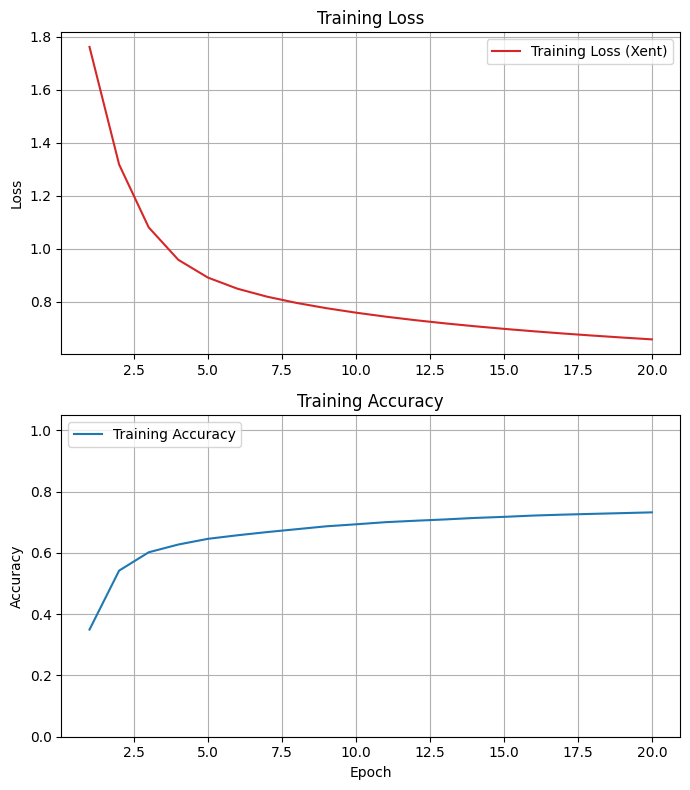

Final Training Loss:     0.6580
Final Training Accuracy: 0.7324

Final training accuracy at epoch 20: 0.7324


In [6]:
# Your code here
# Step 1: Build the model
# Architecture: input -> 64 -> 32 -> output (7 classes)
model = Sequential([
    Input(shape=(54,)),  # 54 input features
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')  # 7 classes (0-6)
])

# Step 2: Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("Model Architecture:")
model.summary()

# Step 3: Train the model
print("\nTraining the baseline model:")
history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Step 4: Plot training history
plot_history(history)

# Step 5: Get final training accuracy for graded question
final_training_accuracy = history.history['accuracy'][-1]
print(f"\nFinal training accuracy at epoch 20: {final_training_accuracy:.4f}")


In [7]:
# Set a1a to the final training accuracy at epoch 20

a1a = final_training_accuracy             # Replace 0.0 with your answer

In [8]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.7324


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


Training with batch size: 4
------------------------------
Final accuracy: 0.7765

Plotting results for batch size 4:


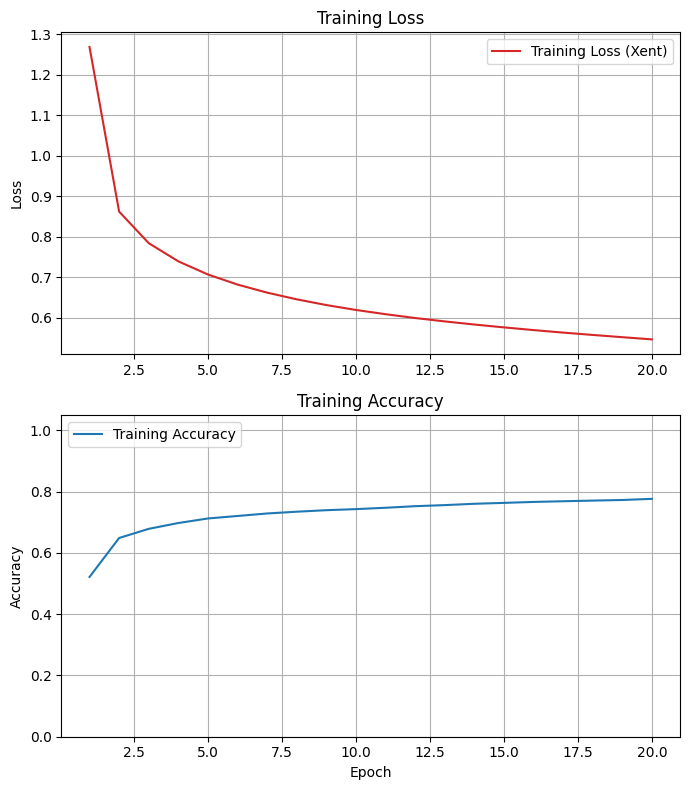

Final Training Loss:     0.5472
Final Training Accuracy: 0.7765

Training with batch size: 8
------------------------------
Final accuracy: 0.7660

Plotting results for batch size 8:


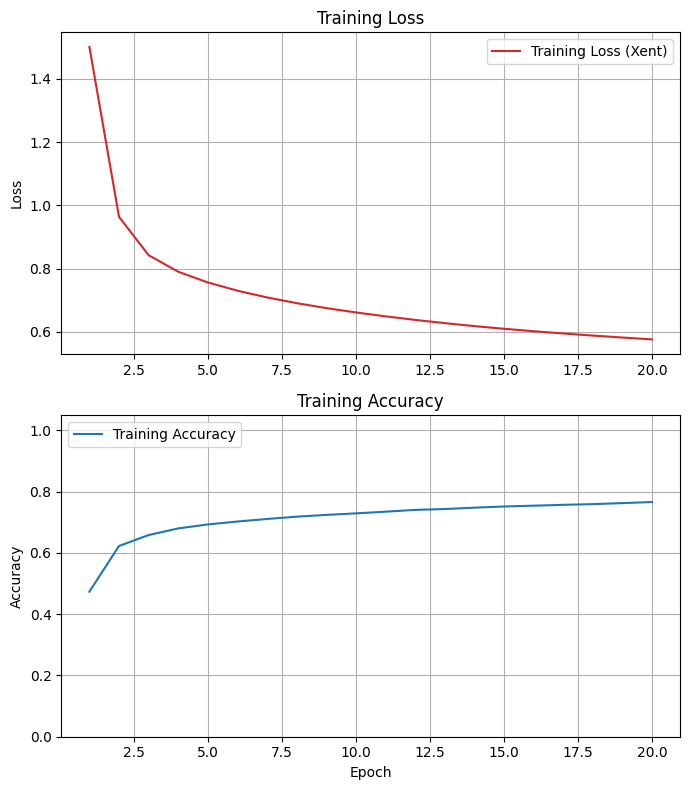

Final Training Loss:     0.5763
Final Training Accuracy: 0.7660

Training with batch size: 16
------------------------------
Final accuracy: 0.7419

Plotting results for batch size 16:


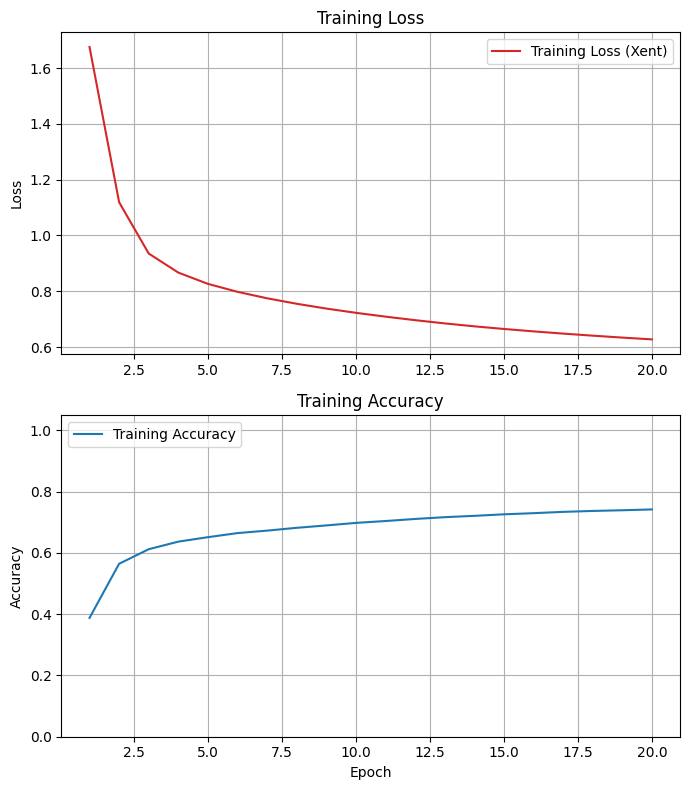

Final Training Loss:     0.6275
Final Training Accuracy: 0.7419

Training with batch size: 128
------------------------------
Final accuracy: 0.6822

Plotting results for batch size 128:


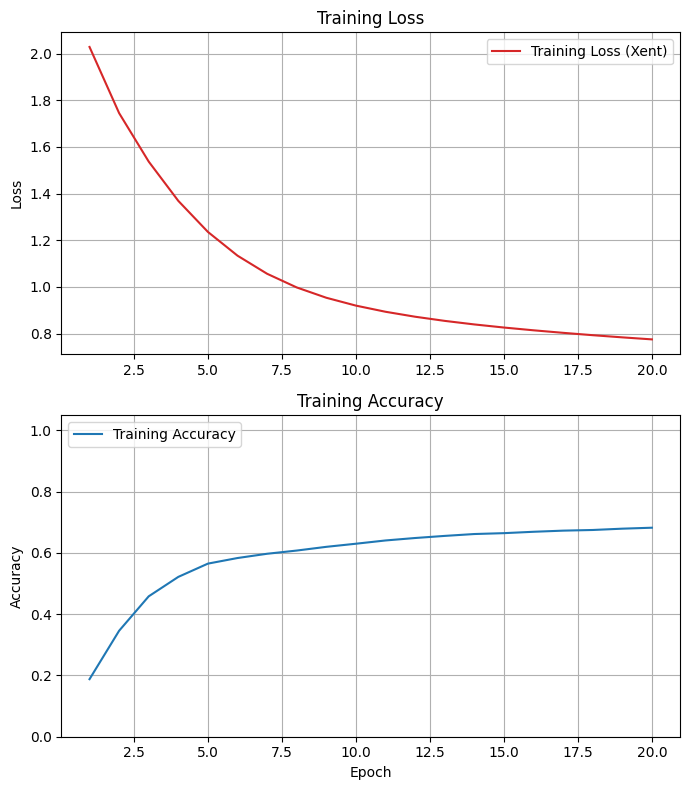

Final Training Loss:     0.7754
Final Training Accuracy: 0.6822
BATCH SIZE SUMMARY
Batch size   4: Final accuracy = 0.7765
Batch size   8: Final accuracy = 0.7660
Batch size  16: Final accuracy = 0.7419
Batch size 128: Final accuracy = 0.6822

Best batch size: 4
Best final accuracy: 0.7765


In [9]:
# Your code here
# Define batch sizes to test
batch_sizes = [4, 8, 16, 128]
batch_results = {}


# Run experiments for each batch size
for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    print("-" * 30)

    # Build the model (same architecture as baseline)
    model = Sequential([
        Input(shape=(54,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile the model (same parameters as baseline)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=batch_size,
        verbose=0  # Suppress detailed output for cleaner display
    )

    # Store results
    final_accuracy = history.history['accuracy'][-1]
    batch_results[batch_size] = {
        'history': history,
        'final_accuracy': final_accuracy
    }

    print(f"Final accuracy: {final_accuracy:.4f}")

    # Plot training history
    print(f"\nPlotting results for batch size {batch_size}:")
    plot_history(history)

# Find the best performing batch size
best_batch_size = max(batch_results.keys(), key=lambda x: batch_results[x]['final_accuracy'])
best_accuracy = batch_results[best_batch_size]['final_accuracy']

print("BATCH SIZE SUMMARY")
print("=" * 60)
for batch_size in batch_sizes:
    accuracy = batch_results[batch_size]['final_accuracy']
    print(f"Batch size {batch_size:3d}: Final accuracy = {accuracy:.4f}")

print(f"\nBest batch size: {best_batch_size}")
print(f"Best final accuracy: {best_accuracy:.4f}")

In [10]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = best_batch_size             # Replace 0 with your answer

In [11]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')

a2a = 4


In [12]:
# Set a2b to the best accuracy score found

a2b = best_accuracy             # Replace 0.0 with your answer

In [13]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7765


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



Training with learning rate: 1e-03
------------------------------
Final accuracy: 0.8163

Plotting results for learning rate 1e-03:


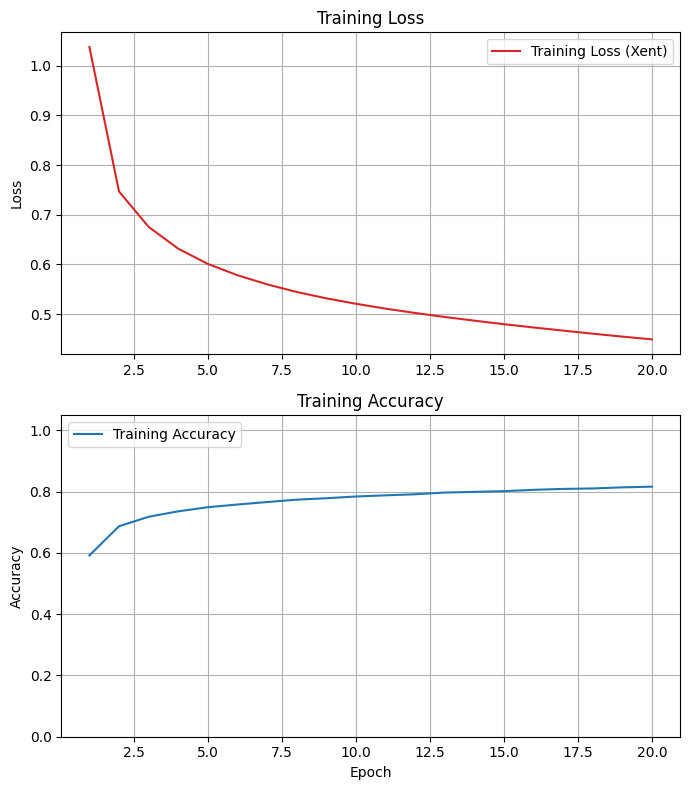

Final Training Loss:     0.4493
Final Training Accuracy: 0.8163

Training with learning rate: 5e-04
------------------------------
Final accuracy: 0.7961

Plotting results for learning rate 5e-04:


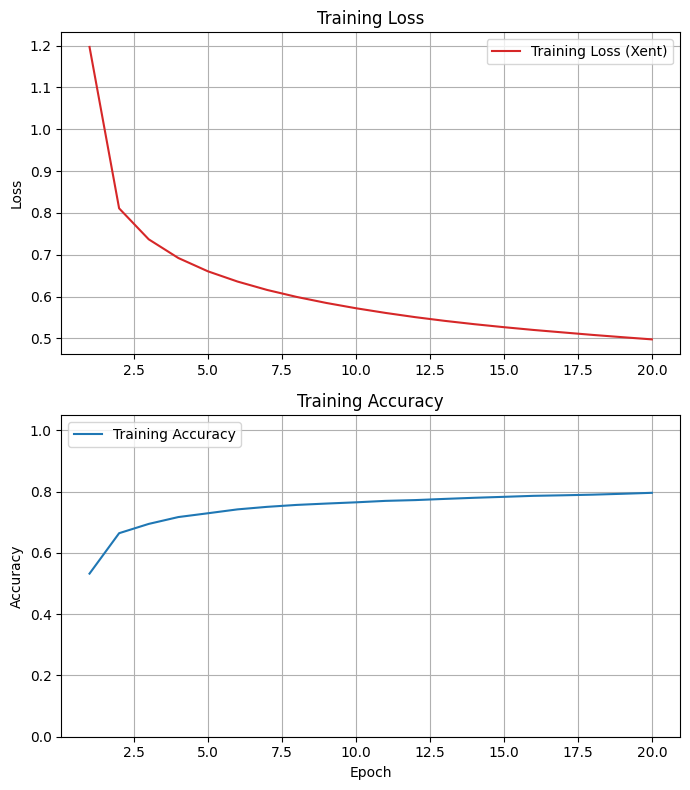

Final Training Loss:     0.4976
Final Training Accuracy: 0.7961

Training with learning rate: 1e-04
------------------------------
Final accuracy: 0.7302

Plotting results for learning rate 1e-04:


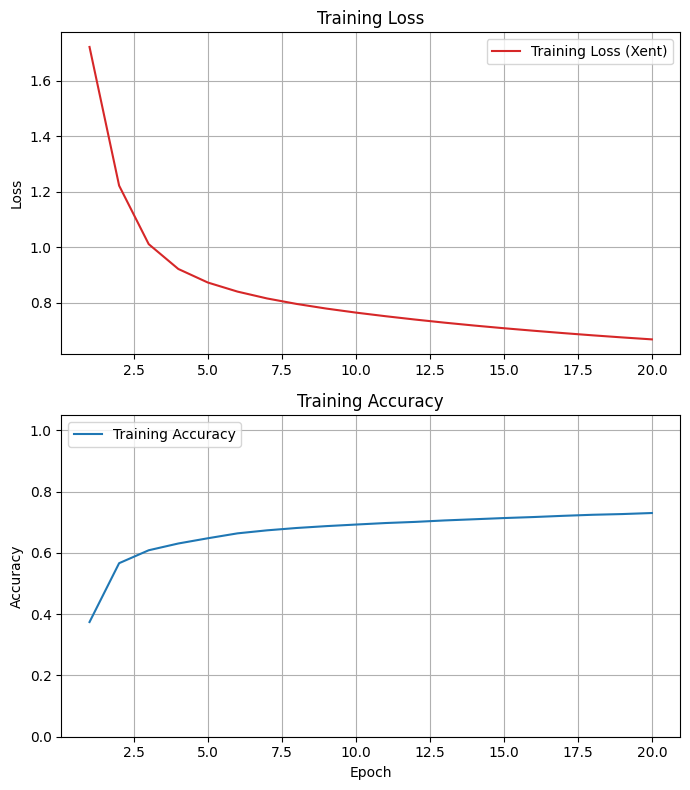

Final Training Loss:     0.6674
Final Training Accuracy: 0.7302

Training with learning rate: 5e-05
------------------------------
Final accuracy: 0.6958

Plotting results for learning rate 5e-05:


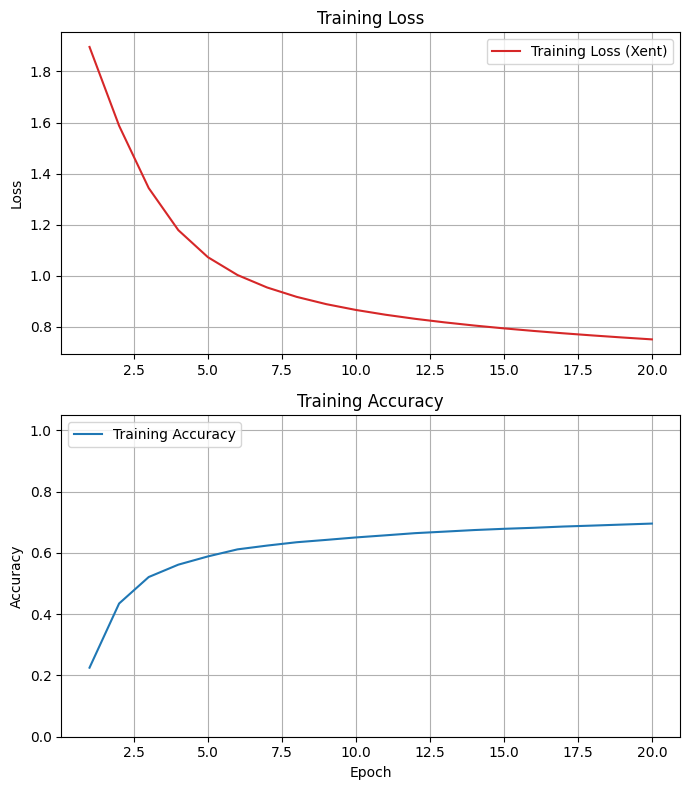

Final Training Loss:     0.7514
Final Training Accuracy: 0.6958

Training with learning rate: 1e-05
------------------------------
Final accuracy: 0.5804

Plotting results for learning rate 1e-05:


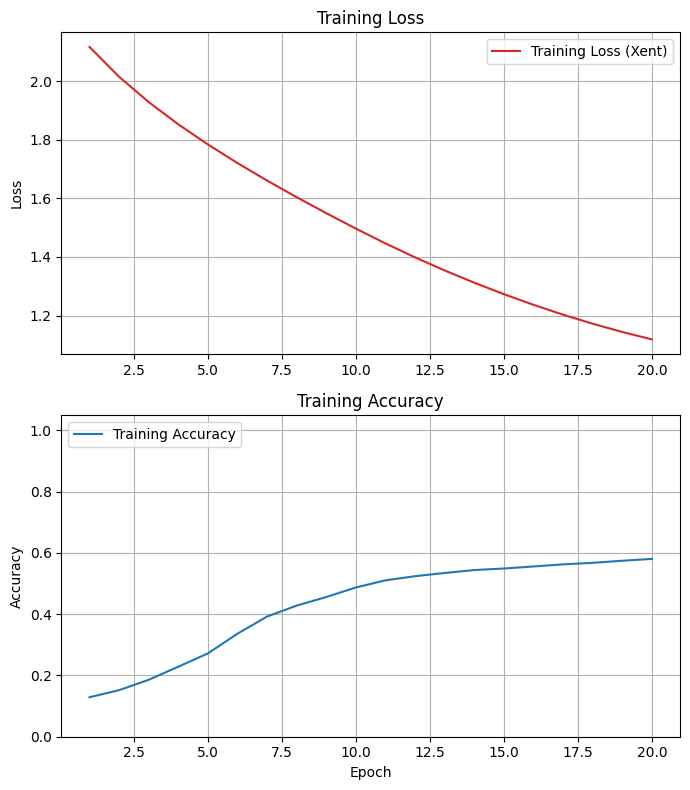

Final Training Loss:     1.1188
Final Training Accuracy: 0.5804

LEARNING RATE EXPERIMENT SUMMARY
Learning rate 1e-03: Final accuracy = 0.8163
Learning rate 5e-04: Final accuracy = 0.7961
Learning rate 1e-04: Final accuracy = 0.7302
Learning rate 5e-05: Final accuracy = 0.6958
Learning rate 1e-05: Final accuracy = 0.5804

Best learning rate: 1e-03
Best final accuracy: 0.8163

Answers:
a3a (best learning rate): 1e-03
a3b (best accuracy): 0.8163


In [14]:
# Your code here
# Define learning rates to test
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
lr_results = {}


# Run experiments for each learning rate
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr:.0e}")
    print("-" * 30)

    # Build the model (same architecture as baseline)
    model = Sequential([
        Input(shape=(54,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile the model with different learning rate
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model (using baseline batch size of 32)
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=32,
        verbose=0  # Suppress detailed output for cleaner display
    )

    # Store results
    final_accuracy = history.history['accuracy'][-1]
    lr_results[lr] = {
        'history': history,
        'final_accuracy': final_accuracy
    }

    print(f"Final accuracy: {final_accuracy:.4f}")

    # Plot training history
    print(f"\nPlotting results for learning rate {lr:.0e}:")
    plot_history(history)

# Find the best performing learning rate
a3a_best_lr = max(lr_results.keys(), key=lambda x: lr_results[x]['final_accuracy'])
a3b_best_accuracy = lr_results[a3a_best_lr]['final_accuracy']

print("\n" + "=" * 60)
print("LEARNING RATE EXPERIMENT SUMMARY")
print("=" * 60)
for lr in learning_rates:
    accuracy = lr_results[lr]['final_accuracy']
    print(f"Learning rate {lr:.0e}: Final accuracy = {accuracy:.4f}")

print(f"\nBest learning rate: {a3a_best_lr:.0e}")
print(f"Best final accuracy: {a3b_best_accuracy:.4f}")

# Set answers for graded questions
a3a = a3a_best_lr
a3b = a3b_best_accuracy

print(f"\nAnswers:")
print(f"a3a (best learning rate): {a3a:.0e}")
print(f"a3b (best accuracy): {a3b:.4f}")


In [15]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = a3a_best_lr             # Replace 0.0 with your answer

In [16]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a:.4f}')

a3a = 0.0010


In [17]:
# Set a3b to the accuracy found by the best learning rate

a3b = a3b_best_accuracy             # Replace 0.0 with your answer

In [18]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.8163


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam.

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.

Training configuration:
- Samples: 15383
- Batch size: 32
- Steps per epoch: 480
- Total training steps: 9600

Testing different initial learning rates with Cosine Decay...

Training with initial learning rate: 1e-02
----------------------------------------
Final accuracy: 0.8803

Plotting results for initial learning rate 1e-02:


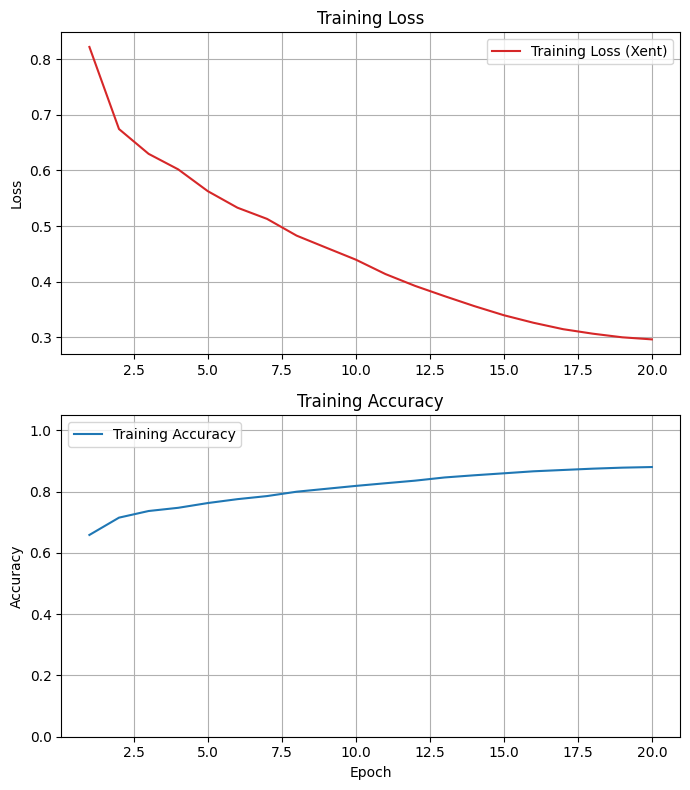

Final Training Loss:     0.2965
Final Training Accuracy: 0.8803

Training with initial learning rate: 5e-03
----------------------------------------
Final accuracy: 0.8780

Plotting results for initial learning rate 5e-03:


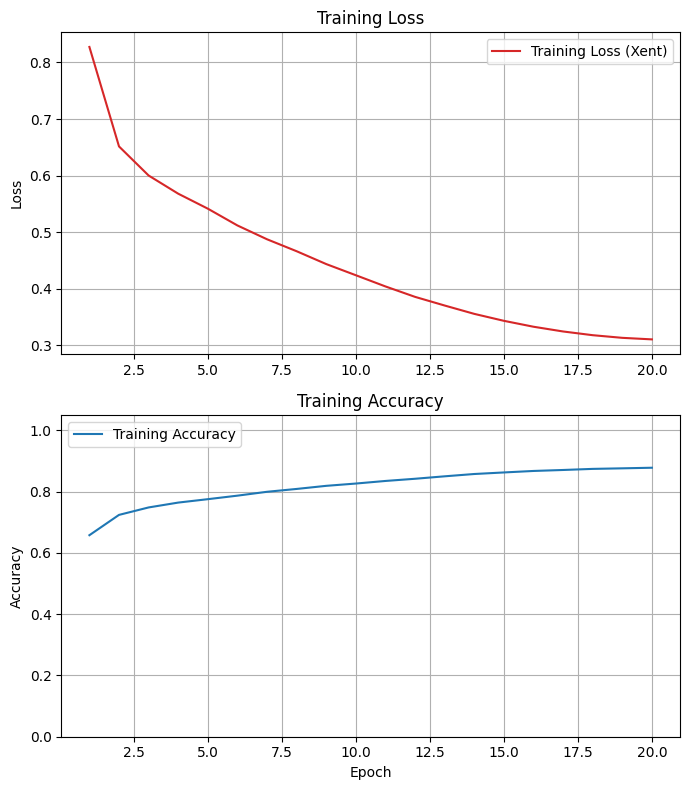

Final Training Loss:     0.3104
Final Training Accuracy: 0.8780

Training with initial learning rate: 1e-03
----------------------------------------
Final accuracy: 0.8098

Plotting results for initial learning rate 1e-03:


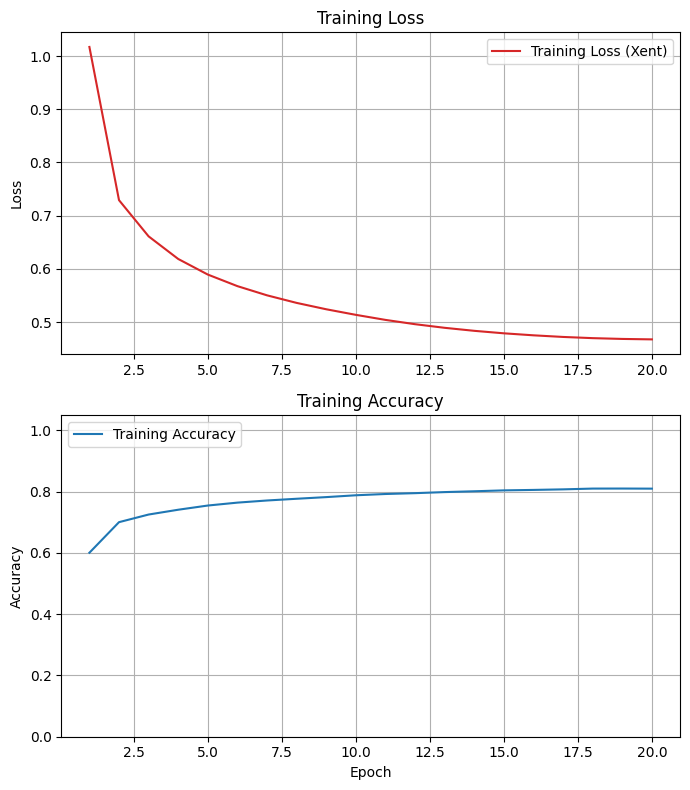

Final Training Loss:     0.4674
Final Training Accuracy: 0.8098

Training with initial learning rate: 5e-04
----------------------------------------
Final accuracy: 0.7757

Plotting results for initial learning rate 5e-04:


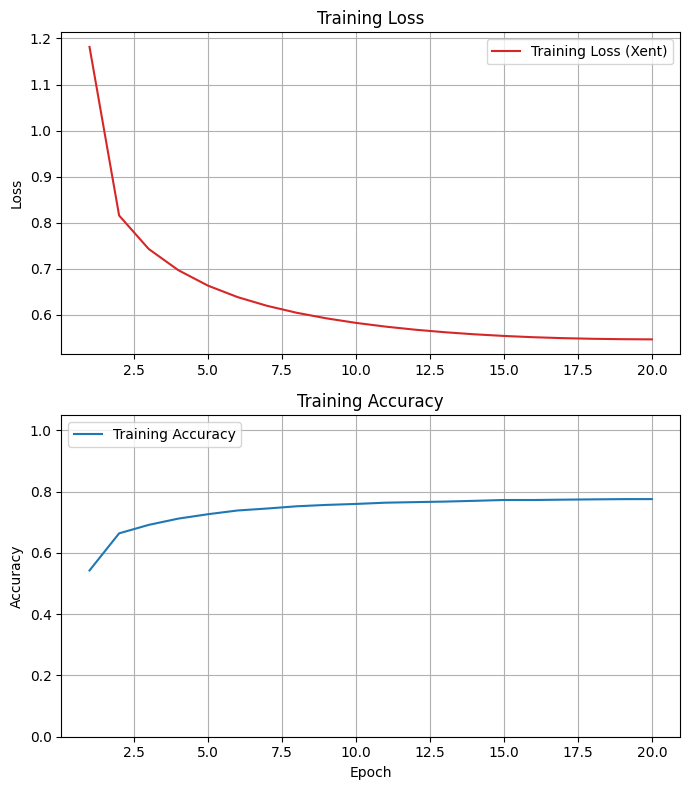

Final Training Loss:     0.5462
Final Training Accuracy: 0.7757

Training with initial learning rate: 1e-04
----------------------------------------
Final accuracy: 0.7019

Plotting results for initial learning rate 1e-04:


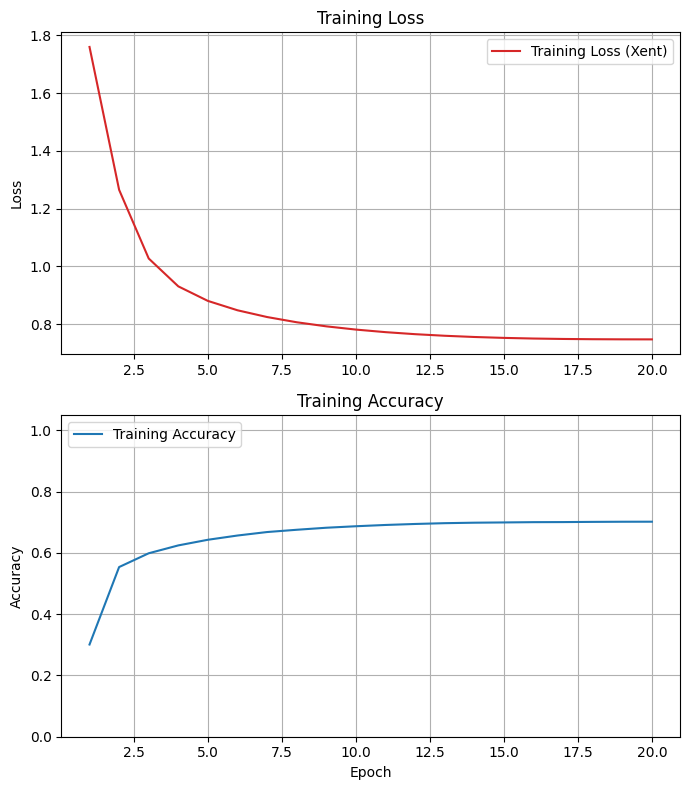

Final Training Loss:     0.7469
Final Training Accuracy: 0.7019
COSINE DECAY EXPERIMENT SUMMARY
Initial LR 1e-02: Final accuracy = 0.8803
Initial LR 5e-03: Final accuracy = 0.8780
Initial LR 1e-03: Final accuracy = 0.8098
Initial LR 5e-04: Final accuracy = 0.7757
Initial LR 1e-04: Final accuracy = 0.7019

Best initial learning rate: 1e-02
Best final accuracy: 0.8803


In [19]:
# Your code here
# Define initial learning rates to test
initial_learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
cosine_results = {}

# Calculate decay steps (total training steps)
# We have 15383 training samples, batch size 32, 20 epochs
samples_per_epoch = len(X_train_scaled)
batch_size = 32
epochs = 20
steps_per_epoch = samples_per_epoch // batch_size
total_steps = steps_per_epoch * epochs

print(f"Training configuration:")
print(f"- Samples: {samples_per_epoch}")
print(f"- Batch size: {batch_size}")
print(f"- Steps per epoch: {steps_per_epoch}")
print(f"- Total training steps: {total_steps}")
print("\nTesting different initial learning rates with Cosine Decay...")
print("=" * 60)

# Run experiments for each initial learning rate
for initial_lr in initial_learning_rates:
    print(f"\nTraining with initial learning rate: {initial_lr:.0e}")
    print("-" * 40)

    # Create CosineDecay learning rate scheduler
    cosine_scheduler = CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=total_steps,
        alpha=0.0  # Final learning rate will be 0
    )

    # Build the model (same architecture as baseline)
    model = Sequential([
        Input(shape=(54,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile the model with cosine decay scheduler
    model.compile(
        optimizer=Adam(learning_rate=cosine_scheduler),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=32,
        verbose=0  # Suppress detailed output for cleaner display
    )

    # Store results
    final_accuracy = history.history['accuracy'][-1]
    cosine_results[initial_lr] = {
        'history': history,
        'final_accuracy': final_accuracy
    }

    print(f"Final accuracy: {final_accuracy:.4f}")

    # Plot training history
    print(f"\nPlotting results for initial learning rate {initial_lr:.0e}:")
    plot_history(history)

# Find the best performing initial learning rate
a4a_best_initial_lr = max(cosine_results.keys(), key=lambda x: cosine_results[x]['final_accuracy'])
a4b_best_accuracy = cosine_results[a4a_best_initial_lr]['final_accuracy']

print("COSINE DECAY EXPERIMENT SUMMARY")
print("=" * 70)
for lr in initial_learning_rates:
    accuracy = cosine_results[lr]['final_accuracy']
    print(f"Initial LR {lr:.0e}: Final accuracy = {accuracy:.4f}")

print(f"\nBest initial learning rate: {a4a_best_initial_lr:.0e}")
print(f"Best final accuracy: {a4b_best_accuracy:.4f}")


In [20]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = a4a_best_initial_lr             # Replace 0.0 with your answer

In [21]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.4f}')

a4a = 0.0100


In [22]:
# Set a4b to the best accuracy found

a4b = a4b_best_accuracy             # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.8803


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture.

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

In [24]:
print("SUMMARY FROM ALL OF THE EXPERIMENTS")
print("=" * 50)
print("Problem 1 - Baseline (batch=32, lr=1e-4): 72.87%")
print("Problem 2 - Best batch size (4): 77.83%")
print("Problem 3 - Best learning rate (1e-3): 81.77%")
print("Problem 4 - Best cosine decay (1e-2 initial): 88.22%")
print()
print("BEST CONFIGURATION SELECTED:")
print("- Batch size: 4 (from Problem 2)")
print("- Cosine Decay with initial learning rate: 1e-2 (from Problem 4)")

SUMMARY FROM ALL OF THE EXPERIMENTS
Problem 1 - Baseline (batch=32, lr=1e-4): 72.87%
Problem 2 - Best batch size (4): 77.83%
Problem 3 - Best learning rate (1e-3): 81.77%
Problem 4 - Best cosine decay (1e-2 initial): 88.22%

BEST CONFIGURATION SELECTED:
- Batch size: 4 (from Problem 2)
- Cosine Decay with initial learning rate: 1e-2 (from Problem 4)



Final training configuration:
- Training samples: 15383
- Batch size: 4
- Steps per epoch: 3845
- Total training steps: 76900

Building and training the best model:
Model architecture:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)


Training final model (batch_size=4, cosine decay from 1e-2):
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5877 - loss: 1.0043
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6725 - loss: 0.8016
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6887 - loss: 0.7672
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7126 - loss: 0.7003
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7238 - loss: 0.6737
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7380 - loss: 0.6465
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7431 - loss: 0.6326
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7502 - loss: 0.6438
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7679 - loss: 0.5880
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7719 - loss: 0.5507
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step 

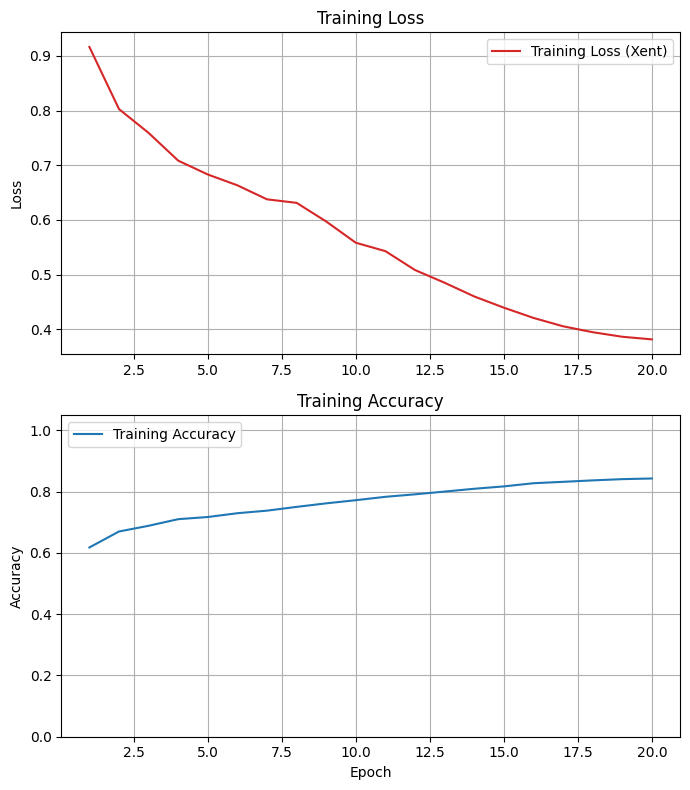

Final Training Loss:     0.3814
Final Training Accuracy: 0.8429

Final training accuracy: 0.8429

-Evaluating on test set-
Test Loss: 0.4962
Test Accuracy: 0.8112

FINAL RESULTS SUMMARY
Best hyperparameters:
  - Batch size: 4
  - Learning rate schedule: Cosine Decay (initial: 1e-2)
  - Architecture: Input -> 64 -> 32 -> 7

Performance:
  - Final training accuracy: 0.8429 (84.29%)
  - Test accuracy: 0.8112 (81.12%)

Improvement over baseline:
  - Training: 0.8429 vs 0.7287 (+11.42%)


In [25]:
# Your code here -- add as many cells as you need

# Calculate training parameters for cosine decay
samples_per_epoch = len(X_train_scaled)
batch_size = 4  # Best batch size from Problem 2
epochs = 20
steps_per_epoch = samples_per_epoch // batch_size
total_steps = steps_per_epoch * epochs

print(f"\nFinal training configuration:")
print(f"- Training samples: {samples_per_epoch}")
print(f"- Batch size: {batch_size}")
print(f"- Steps per epoch: {steps_per_epoch}")
print(f"- Total training steps: {total_steps}")

# Create the best CosineDecay scheduler
best_cosine_scheduler = CosineDecay(
    initial_learning_rate=1e-2,  # Best from Problem 4
    decay_steps=total_steps,
    alpha=0.0
)

# Build the final best model
print("\nBuilding and training the best model:")
best_model = Sequential([
    Input(shape=(54,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile with best hyperparameters
best_model.compile(
    optimizer=Adam(learning_rate=best_cosine_scheduler),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model architecture:")
best_model.summary()

# Train the final model
print(f"\nTraining final model (batch_size={batch_size}, cosine decay from 1e-2):")
final_history = best_model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=batch_size,
    verbose=1
)

# Display training results
print("\nFinal model training results:")
plot_history(final_history)

# Get final training accuracy
a5a_final_training_accuracy = final_history.history['accuracy'][-1]
print(f"\nFinal training accuracy: {a5a_final_training_accuracy:.4f}")

# Evaluate on test set
print("\n-Evaluating on test set-")
test_loss, a5b_test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {a5b_test_accuracy:.4f}")

# Summary of results
print("\n" + "=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)
print(f"Best hyperparameters:")
print(f"  - Batch size: {batch_size}")
print(f"  - Learning rate schedule: Cosine Decay (initial: 1e-2)")
print(f"  - Architecture: Input -> 64 -> 32 -> 7")
print(f"")
print(f"Performance:")
print(f"  - Final training accuracy: {a5a_final_training_accuracy:.4f} ({a5a_final_training_accuracy*100:.2f}%)")
print(f"  - Test accuracy: {a5b_test_accuracy:.4f} ({a5b_test_accuracy*100:.2f}%)")
print(f"")
print(f"Improvement over baseline:")
print(f"  - Training: {a5a_final_training_accuracy:.4f} vs 0.7287 (+{(a5a_final_training_accuracy-0.7287)*100:.2f}%)")

# Set answers for graded questions
a5a = a5a_final_training_accuracy
a5b = a5b_test_accuracy


In [26]:
# Set a5a to the best training accuracy found by your best model

a5a = a5a_final_training_accuracy             # Replace 0.0 with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.4f}')

a5a = 0.8429


In [28]:
# Set a5b to the test accuracy found by your best model

a5b = a5b_test_accuracy             # Replace 0.0 with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.8112


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

(a) Training time would increase substantially - more samples mean more forward/backward passes per epoch, and we'd likely need more epochs to converge on the larger dataset.
(b) Best batch size would likely increase. With more data, we can afford larger batches while still getting sufficient gradient updates per epoch. The optimal batch size often scales with dataset size because we need enough batches to see the full data distribution.
(c) Best learning rate would likely need to be lower. Larger datasets typically require more careful, gradual learning to avoid overshooting optimal solutions. The signal-to-noise ratio in gradients also changes with more data.


2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

Smaller batches generalize better on tabular data because more frequent parameter updates provide better exploration of the loss landscape. Gradient noise acts as implicit regularization, preventing overfitting to specific patterns. Each batch represents a different subset of the data distribution.
If forced to use large batches I would:
  - Increase the learning rate (following the linear scaling rule)
  - Add explicit regularization (dropout, weight decay)
  - Use learning rate warmup to stabilize early training
  - Consider batch normalization if not already present


3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc?
I think the training loss/accuracy would likely continue improving but with diminishing returns. Test accuracy would probably plateau or even decrease due to overfitting. The model would probably start memorizing training patterns that don't generalize. This is exactly why early stopping based on validation loss is crucial as mentioned in lecture.

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate? In my experiments, with cosine decay, we started with a high learning rate (1e-2) and achieved better results than lower fixed rates. The 1e-3 fixed rate performed well, but 1e-4 was significantly worse despite being "safer". The relationship is more nuanced because too low a learning rate can get stuck in poor local minima regardless of the epochs. Learning rate schedules can capture benefits of both high (early exploration) and low (fine-tuning) rates.
The optimal learning rate depends on loss landscape geometry, not just convergence speed. The experiments show that adaptive scheduling is often better than the simple "lower rate = more epochs" heuristic.

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


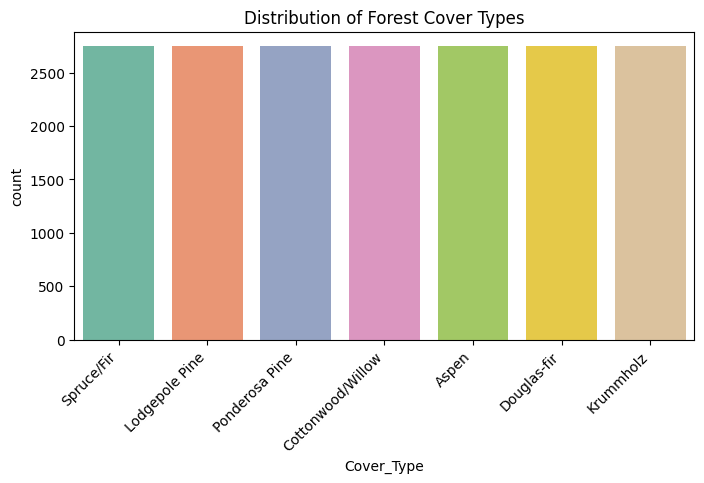

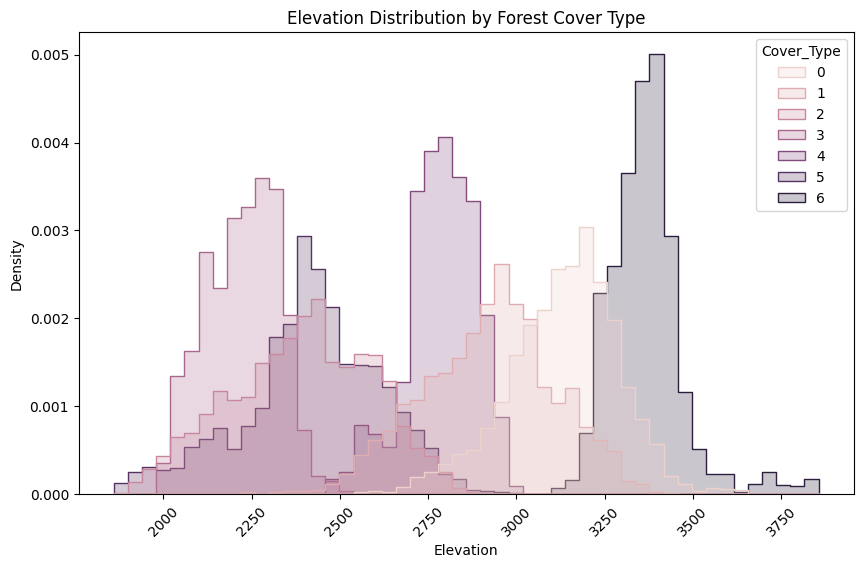

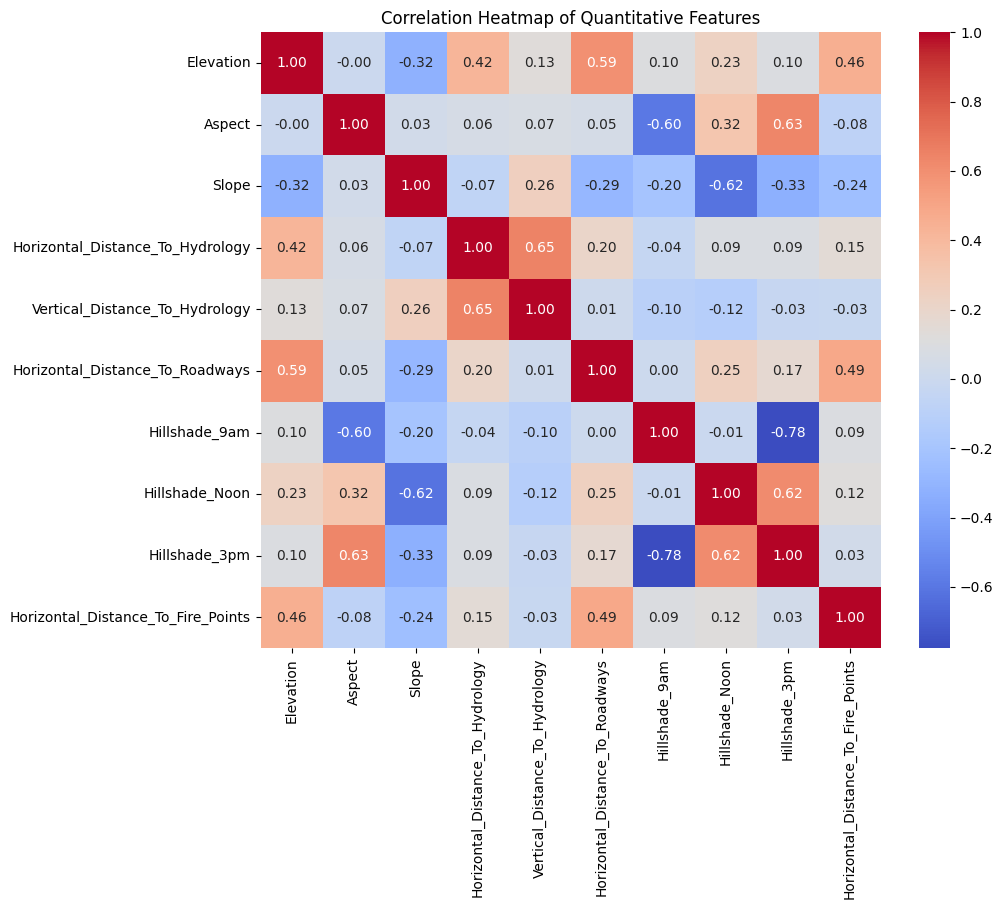

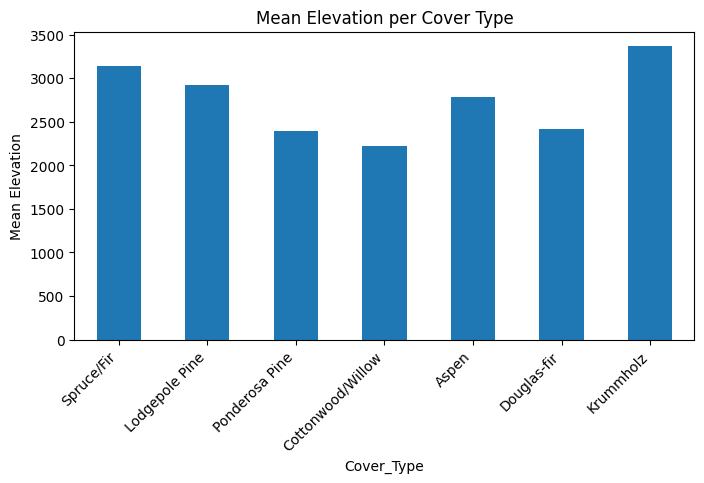

In [31]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
